<a href="https://colab.research.google.com/github/Hyeji-Han/Waste-Classification/blob/main/waste_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Library download and import 
!pip install lime
!pip install colorama
!pip install opencv-python
!git clone https://github.com/samson6460/tf_keras_gradcamplusplus.git ./assets/tf_keras_gradcamplusplus
    
# Download assets from the GitHub repository
!apt install subversion

import os
import sys
import re
import random
import shutil
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from colorama import Fore, Style
from PIL import Image, ImageFile
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Layer
from keras.models import Sequential
from keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.preprocessing import image
from glob import glob
from assets.tf_keras_gradcamplusplus.utils import preprocess_image
from assets.tf_keras_gradcamplusplus.gradcam import grad_cam, grad_cam_plus
from IPython.display import clear_output

clear_output()
print(Fore.GREEN + u'\u2713 ' + 'Successfully downloaded dependencies.')    
print(Style.RESET_ALL)

In [ ]:
class IgnorePrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Set testset

In [ ]:
# set directory for train, test 
TRAIN_DIRECTORY = '/content/drive/MyDrive/trash_image/train/'
TEST_DIRECTORY = '/content/drive/MyDrive/trash_image/test/'

# Hyper Params

In [ ]:
CLASSES = ('cardboard', 'glass', 'metal', 'plastic')

SEED = 68765
IMAGE_SHAPE_2D = (224, 224)
IMAGE_SHAPE_3D = (224, 224, 3)

EPOCHS = 50
LEARNING_RATE = 0.001

BASE_MODEL = ResNet50(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE_3D)
PREPROCESSING_METHOD = preprocessing_function=tf.keras.applications.resnet50.preprocess_input


94765736/94765736 [==============================] - 7s 0us/step


# Set explain_dict

* example : decomposition time

In [ ]:
explain_dict = {"cardboard" : "Decomposes in few Months" , 
                "glass": "Decomposes in 1 Million Years. \n Glass is very resilient and takes a very long time to break down, if ever. Glass usually doesn’t decompose completely but breaks down into smaller pieces.", 
                "metal": "Decomposes in 200 Years" , 
                "plastic": "Decomposes in 450 Years"}

Functions

In [ ]:
 def predict_image_class(img, model):
  img = np.expand_dims(img, axis=0)
  preprocessed_image = image_preprocess(img)
  tensor = tf.convert_to_tensor(preprocessed_image, dtype=tf.float32)
  print(Fore.GREEN + u'\n\u2713 ' + f'Model Output ==> {CLASSES[np.argmax(model.predict(tensor))]}')    
  print(explain_dict[CLASSES[np.argmax(model.predict(tensor))]])
  print(Style.RESET_ALL)
  
def show_image(img):
  img = Image.fromarray(img)  
  display(img)

def path_to_image(image_name = None):

  img = Image.open(image_name)
  img = img.resize(IMAGE_SHAPE_2D)    
  img = np.expand_dims(img, axis=0)
  return np.vstack([img])[0]

def image_preprocess(img):
  return PREPROCESSING_METHOD(img)

def explain_image_lime(img, model):
  with IgnorePrints():
      preprocessedImage = image_preprocess(img)

      explainer = lime_image.LimeImageExplainer()
      explanation = explainer.explain_instance(np.asanyarray(preprocessedImage).astype('double'), model.predict, top_labels=5, hide_color=0, num_samples=1000)

      temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
        
  return mark_boundaries(img, mask)

def show_imgwithheat(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (heatmap*255).astype("uint8")
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype("uint8")
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return superimposed_img

def explain_image_grad_cam(img, model):
  image_path = './assets/buffer.jpg'  
  Image.fromarray(img).save(image_path)
    
  img = preprocess_image(image_path, target_size=IMAGE_SHAPE_2D)
  preprocessed_image = image_preprocess(img)
    
  heatmap = grad_cam(
    model, preprocessed_image,
    layer_name = model.layers[1].name,
  )
    
  img_arr = show_imgwithheat(image_path, heatmap)
  os.remove(image_path)
    
  return img_arr

def explain_image_grad_cam_plus_plus(img, model):
  image_path = './assets/buffer.jpg'   
  Image.fromarray(img).save(image_path)
    
  img = preprocess_image(image_path, target_size=IMAGE_SHAPE_2D)
  preprocessed_image = image_preprocess(img)

  heatmap = grad_cam_plus(
    model, preprocessed_image,
    layer_name = model.layers[1].name,
  )
    
  show_imgwithheat(image_path, heatmap)

  img_arr = show_imgwithheat(image_path, heatmap)

  os.remove(image_path)
    
  return img_arr

def plot_XAI(img, model):
  plt.rcParams["figure.figsize"] = (10,10)
  fig, ax = plt.subplots(2,2)
  ax[0,0].imshow(img)
  ax[0,1].imshow(explain_image_lime(img, model))
  ax[1,0].imshow(explain_image_grad_cam(img, model))
  ax[1,1].imshow(explain_image_grad_cam_plus_plus(img, model))

  ax[0, 0].set_title("Original Image")
  ax[0, 1].set_title("LIME")
  ax[1, 0].set_title("Grad-CAM")
  ax[1, 1].set_title("Grad-CAM++")

  fig.tight_layout()
  plt.show()
  plt.rcParams["figure.figsize"] = (15,8)

In [ ]:
# Learning Model 
def build_model(measure_performance:bool = True):
  ImageFile.LOAD_TRUNCATED_IMAGES = True

  train_batches = ImageDataGenerator(preprocessing_function=PREPROCESSING_METHOD).flow_from_directory(directory=TRAIN_DIRECTORY, target_size=IMAGE_SHAPE_2D, classes=CLASSES, batch_size=128)
  test_batches =  ImageDataGenerator(preprocessing_function=PREPROCESSING_METHOD).flow_from_directory(directory=TEST_DIRECTORY, target_size=IMAGE_SHAPE_2D, classes=CLASSES, batch_size=128, shuffle=False)

  input_shape = IMAGE_SHAPE_3D
  nclass = len(CLASSES)
  epoch = EPOCHS
  base_model = BASE_MODEL
  base_model.trainable = False

  add_model = Sequential()
  add_model.add(base_model)
  add_model.add(Layer())
  add_model.add(GlobalAveragePooling2D())
  add_model.add(Dropout(0.5))
  add_model.add(Dense(nclass, activation='softmax'))

  model = add_model
  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
  es = EarlyStopping(monitor='loss', mode='auto', verbose=1, patience = 15) #val_loss

  ###
  fitted_model= model.fit(x=train_batches, epochs=epoch, callbacks=[es]) #validation_data=valid_batches,
  score, accuracy = model.evaluate(x=test_batches, batch_size=64) #128

  print(Fore.GREEN + u'\n\u2713 ' + f'Accuracy ==> {accuracy}')   

  plt.rcParams["figure.figsize"] = (15,8) 

  if measure_performance:
    plt.plot(fitted_model.history['accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()

    plt.plot(fitted_model.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()
    
    y_pred = model.predict(test_batches)
    
    ax = sns.heatmap(confusion_matrix(test_batches.classes, y_pred.argmax(axis=1)), annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    ax.xaxis.set_ticklabels(CLASSES)
    ax.yaxis.set_ticklabels(CLASSES)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()
  
  return model

In [ ]:
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Found 1636 images belonging to 4 classes.
Found 160 images belonging to 4 classes.
Epoch 1/50
13/13 [==============================] - 983s 74s/step - loss: 1.3405 - accuracy: 0.5177
Epoch 2/50
13/13 [==============================] - 10s 711ms/step - loss: 0.6864 - accuracy: 0.7188
Epoch 3/50
13/13 [==============================] - 9s 704ms/step - loss: 0.5650 - accuracy: 0.7842
Epoch 4/50
13/13 [==============================] - 10s 706ms/step - loss: 0.4618 - accuracy: 0.8185
Epoch 5/50
13/13 [==============================] - 9s 699ms/step - loss: 0.4221 - accuracy: 0.8295
Epoch 6/50
13/13 [==============================] - 9s 691ms/step - loss: 0.3980 - accuracy: 0.8460
Epoch 7/50
13/13 [==============================] - 9s 689ms/step - loss: 0.3481 - accuracy: 0.8649
Epoch 8/50
13/13 [==============================] - 9s 699ms/step - loss: 0.2998 - accuracy: 0.8845
Epoch 9/50
13/13 [==============================] - 9s 712ms/step - loss: 0.2893 - accuracy: 0.8979
Epoch 10/50
13/

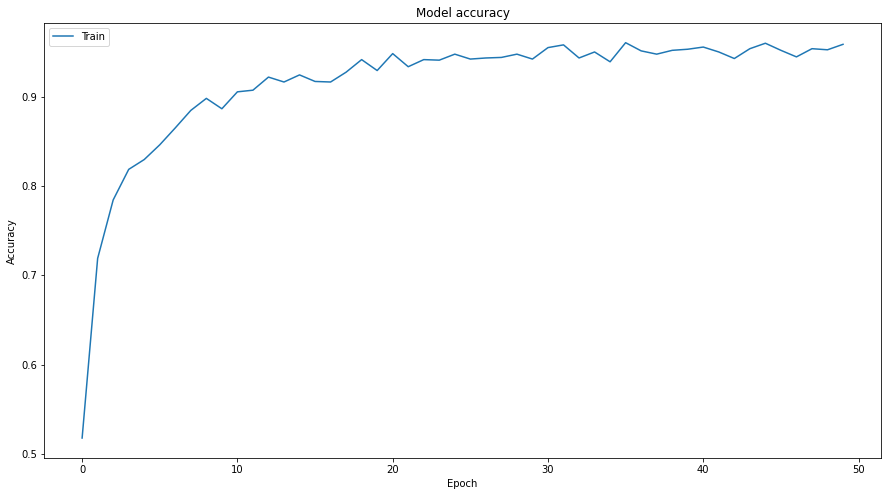

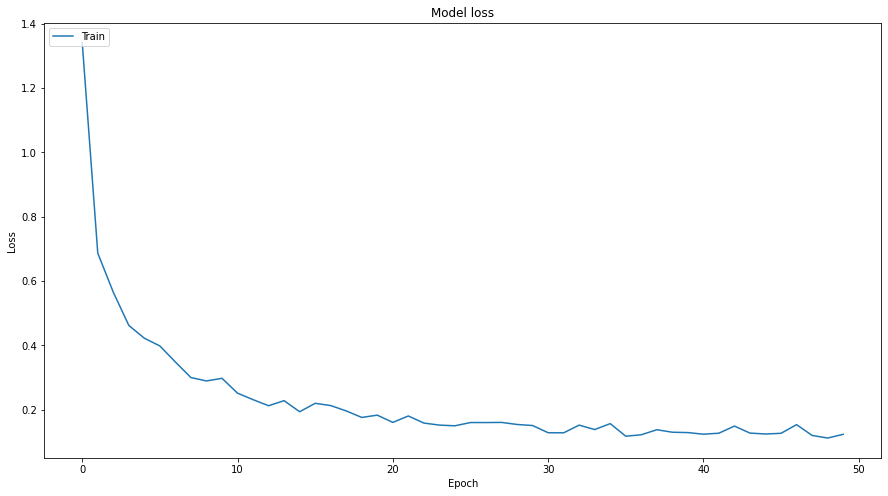

2/2 [==============================] - 2s 432ms/step


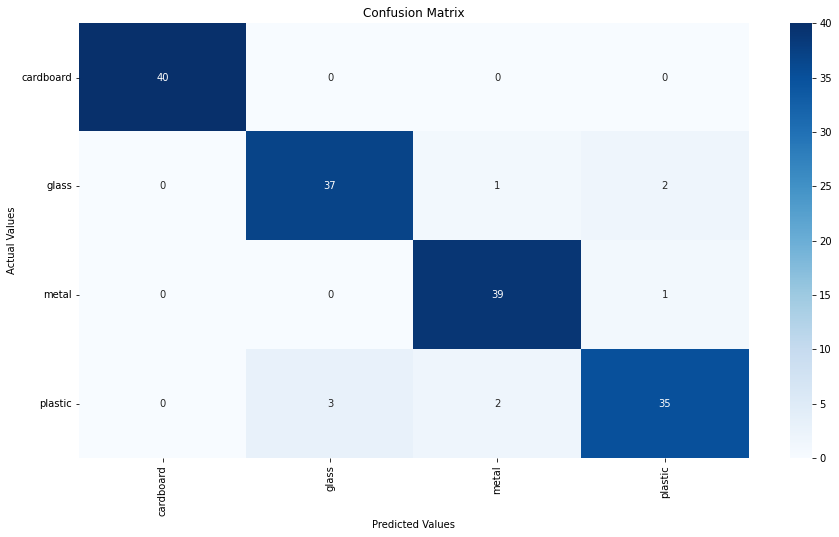

In [ ]:
# Classification model learning and evaluation
# Epoch's accuracy = train accuracy
# Last Accuracy = test accuracy 
# Image = trainset result plot 
model = build_model(measure_performance=True)


# XAI(Explainable AI) Function 
* XAI : Insight into which area the model focused when performing classification

  0%|          | 0/1000 [00:00<?, ?it/s]

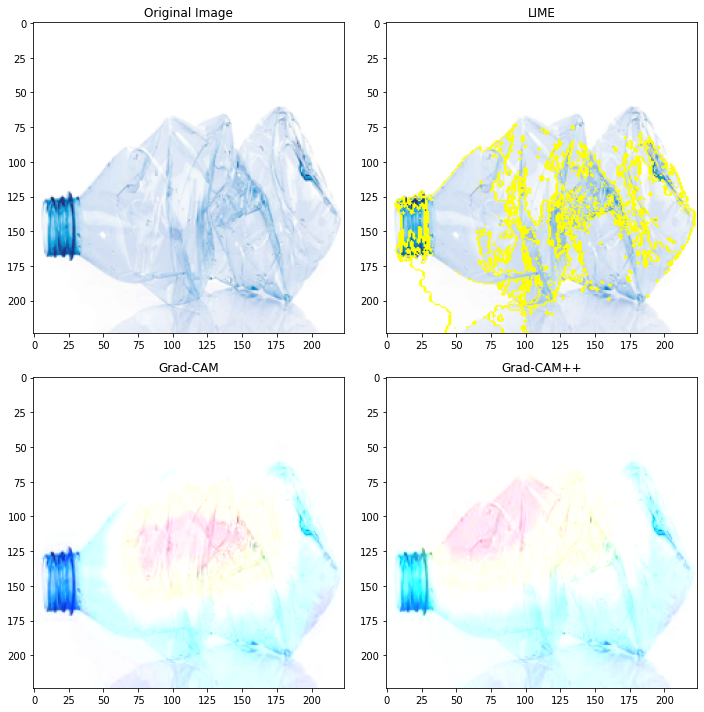

1/1 [==============================] - 0s 39ms/step

✓ Model Output ==> plastic
1/1 [==============================] - 0s 21ms/step
Decomposes in 450 Years



In [ ]:
# XAI for test image
img = path_to_image(TEST_DIRECTORY + 'plastic10000.jpeg')

plot_XAI(img, model)
predict_image_class(img, model)

  0%|          | 0/1000 [00:00<?, ?it/s]

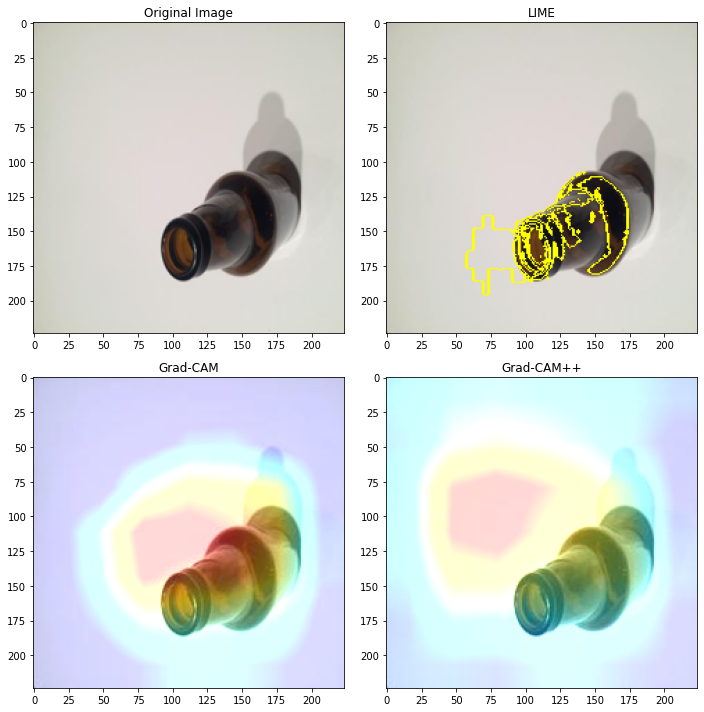

1/1 [==============================] - 0s 27ms/step

✓ Model Output ==> glass
1/1 [==============================] - 0s 20ms/step
Decomposes in 1 Million Years



In [ ]:
# XAI for test image
img = path_to_image(TEST_DIRECTORY + 'glass/glass1.jpg')

plot_XAI(img, model)
predict_image_class(img, model)

  0%|          | 0/1000 [00:00<?, ?it/s]

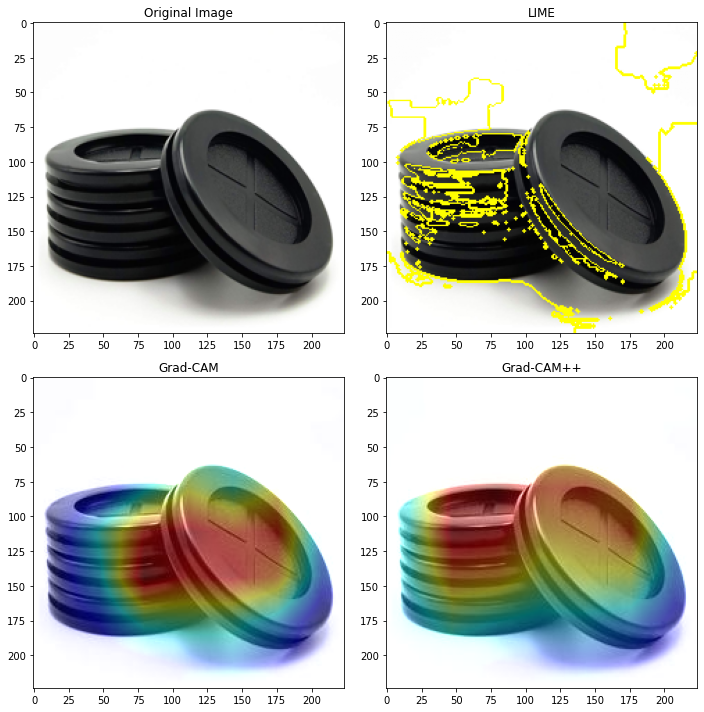

1/1 [==============================] - 0s 37ms/step

✓ Model Output ==> metal
1/1 [==============================] - 0s 20ms/step
Decomposes in 200 Years



In [ ]:
# XAI for test image
img = path_to_image(TEST_DIRECTORY + 'rubber.jpeg')

plot_XAI(img, model)
predict_image_class(img, model)

  0%|          | 0/1000 [00:00<?, ?it/s]

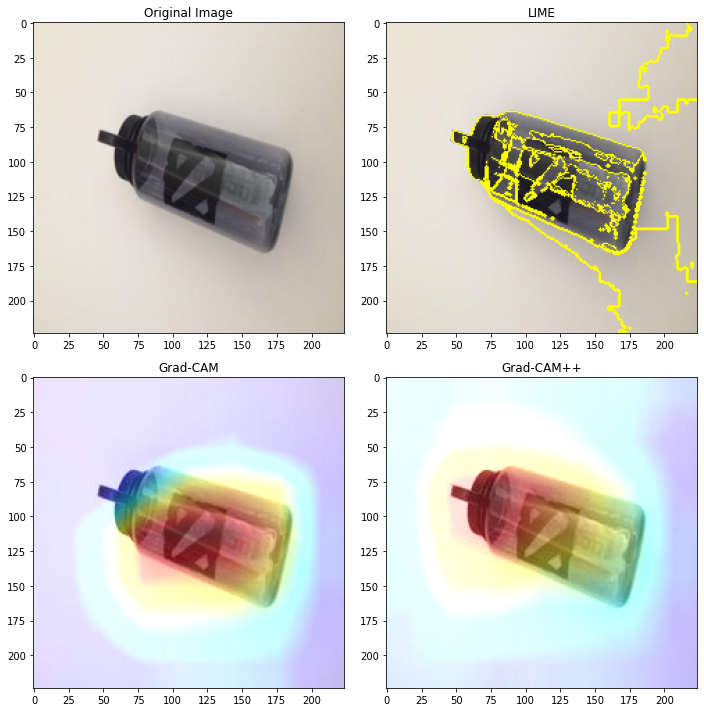

1/1 [==============================] - 0s 35ms/step

✓ Model Output ==> plastic
1/1 [==============================] - 0s 31ms/step
Decomposes in 450 Years



In [ ]:
# XAI for test image
img = path_to_image(TEST_DIRECTORY + 'plastic/plastic1.jpg')

plot_XAI(img, model)
predict_image_class(img, model)

In [ ]:
# Simple ver. result for test image
img = path_to_image(TEST_DIRECTORY + 'plastic/plastic2.jpg')

predict_image_class(img, model)

1/1 [==============================] - 0s 24ms/step

✓ Model Output ==> plastic
1/1 [==============================] - 0s 21ms/step
Decomposes in 450 Years

